### [Story](https://www.pivotaltracker.com/story/show/187949220)
### [Source](https://medium.com/@prathammodi001/keras-cnn-tutorial-classifying-images-made-easy-fb55cc8892ec)

Create from scratch a CNN apllied to computer vision, to classify cats and dogs from a well known image dataset published in [Kaggle](https://www.kaggle.com/c/dogs-vs-cats/overview).

## Dog Breed Classifier CNN

In [47]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [48]:
print(tf.__version__)
if tf.config.list_logical_devices('GPU'):
    print("Yes,  GPU available")
else:
    print("No GPU available")

2.15.1
No GPU available


### Dataset 

In [49]:
# Load dataset
pd.set_option('display.max_columns', None) # show all columns
pd.set_option('display.max.rows', None) # showw all rows

labels_csv = pd.read_csv("./dataset/labels.csv")
labels_csv.describe()

id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

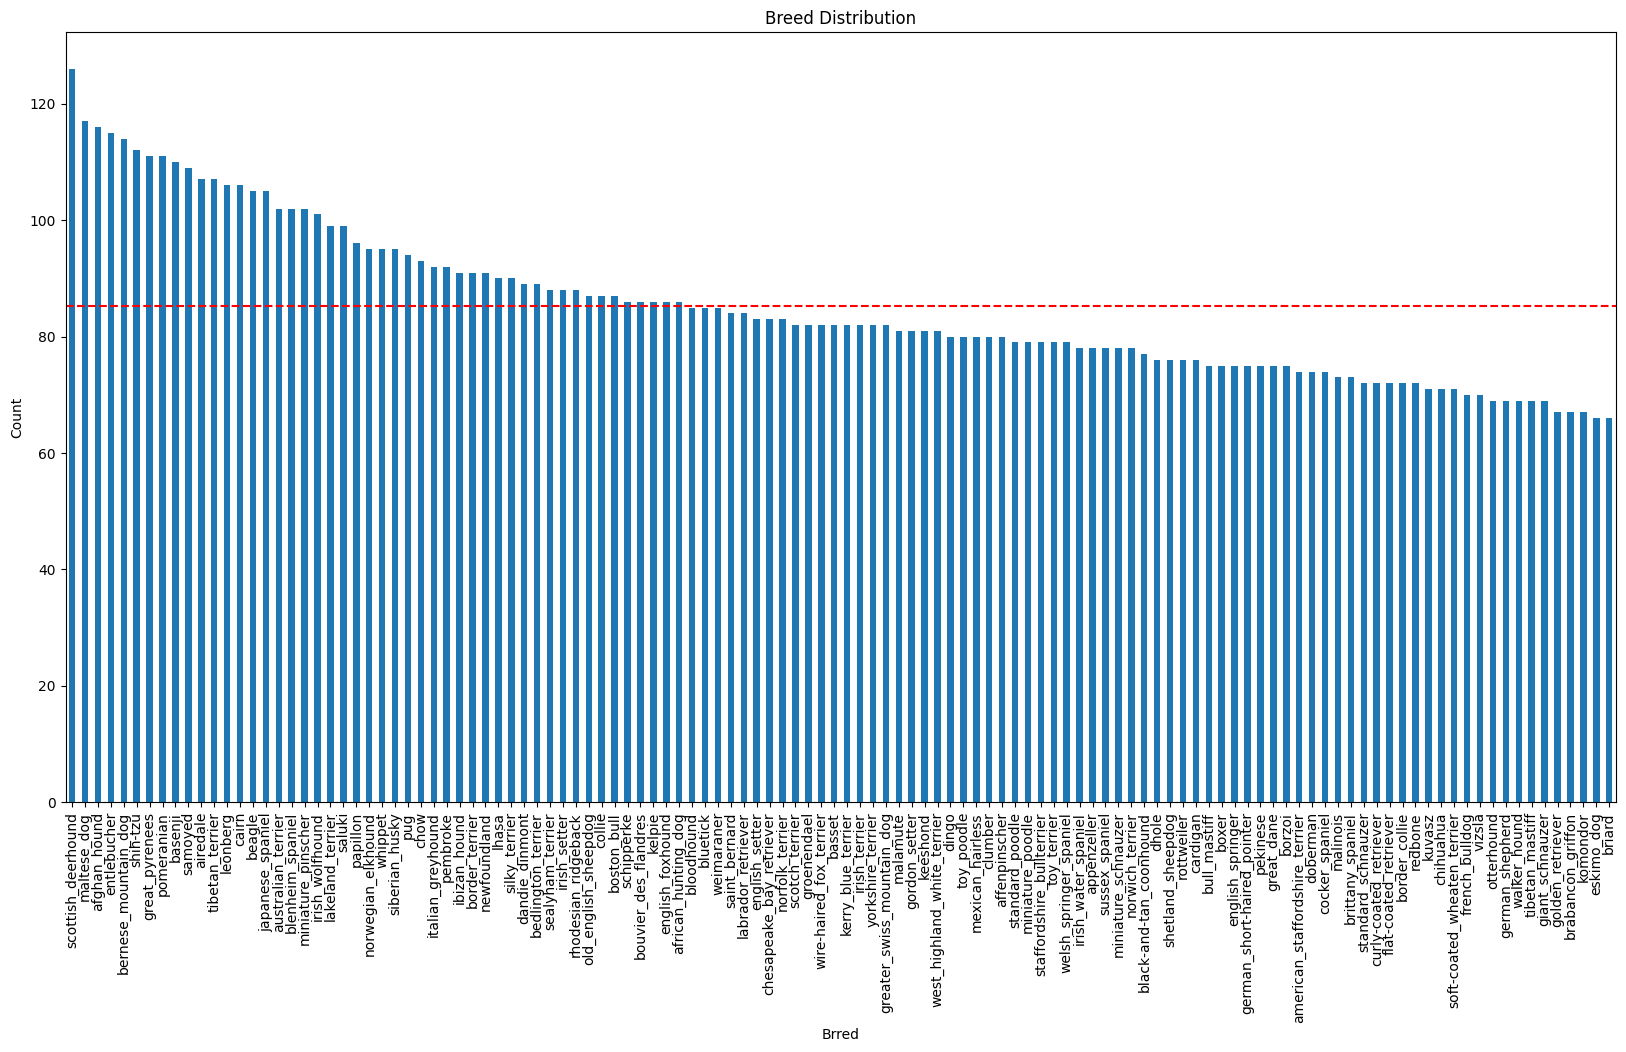

In [50]:
# EDA (exploratory data analysis)
ax = labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

average_value = labels_csv["breed"].value_counts().mean()
ax.axhline(average_value, color="red", linestyle="--", label="Average")

plt.xlabel("Brred")
plt.ylabel("Count")
plt.title("Breed Distribution")
plt.legend


### Get images and their labels

In [51]:
from IPython.display import Image

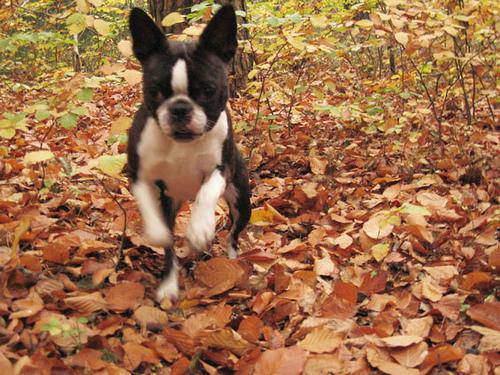

In [52]:
# Test one image
for image in labels_csv["id"].head(1):
    display(Image(filename="./dataset/train/"+image+".jpg", width=300, height="300"))

In [53]:
# get al images
filenames = []
for image_id in labels_csv["id"]:
    filenames.append("./dataset/train/"+image_id+".jpg")

filenames

['./dataset/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 './dataset/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 './dataset/train/001cdf01b096e06d78e9e5112d419397.jpg',
 './dataset/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 './dataset/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 './dataset/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 './dataset/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 './dataset/train/002a283a315af96eaea0e28e7163b21b.jpg',
 './dataset/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 './dataset/train/0042188c895a2f14ef64a918ed9c7b64.jpg',
 './dataset/train/004396df1acd0f1247b740ca2b14616e.jpg',
 './dataset/train/0067dc3eab0b3c3ef0439477624d85d6.jpg',
 './dataset/train/00693b8bc2470375cc744a6391d397ec.jpg',
 './dataset/train/006cc3ddb9dc1bd827479569fcdc52dc.jpg',
 './dataset/train/0075dc49dab4024d12fafe67074d8a81.jpg',
 './dataset/train/00792e341f3c6eb33663e415d0715370.jpg',
 './dataset/train/007b5a16db9d9ff9d7ad39982703e429.jpg',
 './dataset/train/007b8a0788282

In [54]:
# check if all filenames of all images have been acquired
if len(os.listdir("./dataset/train")) == len(filenames):
    print("Correct! Filenames match amount of files!")
else:
    print("Error! Filenames do not match amount of files")

Correct! Filenames match amount of files!


### labels

In [55]:
labels = labels_csv["breed"].to_numpy()

labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [56]:
# check for missing data, lables or images
if len(filenames) == len(labels):
    print("No missing Data!")
else:
    print("Missing data!!!")

No missing Data!


In [57]:
unique_breeds = labels
labels[0] == unique_breeds

boolean_labels = []

for label in labels:
    boolean_labels.append(label == unique_breeds)

## Prepare Train, Valid and Test sets

In [58]:
X = filenames
y = boolean_labels

NUM_IMAGES= 1000

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2, random_state=42)
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

## Images to tensors

1. Take an image as input
2. Use Tensorflow to read the file and save it to a variable `image`
3. Turn the `image` (.jpeg) into Tensors
4. Normalize the `image`
5. Resize the `image` to 224x224
6. Return the processed image

In [59]:
# test 1
image = plt.imread(filenames[42])
image.shape

(257, 350, 3)

In [60]:
# Test 2. 
tensor = tf.io.read_file(filenames[20])
#tensor

In [61]:
# Test 3. Normalization: Turn image into numerical Tensor values: 0-255 (RGB)
tensor = tf.image.decode_jpeg(tensor, channels=3)
tensor

<tf.Tensor: shape=(375, 500, 3), dtype=uint8, numpy=
array([[[125, 128, 117],
        [121, 124, 113],
        [114, 120, 108],
        ...,
        [ 96, 124,  65],
        [ 95, 123,  64],
        [ 99, 127,  68]],

       [[116, 119, 108],
        [112, 118, 106],
        [109, 115, 103],
        ...,
        [ 94, 122,  61],
        [ 92, 120,  59],
        [ 95, 123,  62]],

       [[112, 118, 108],
        [110, 118, 107],
        [109, 117, 106],
        ...,
        [ 92, 121,  57],
        [ 88, 117,  53],
        [ 89, 118,  54]],

       ...,

       [[228, 227, 225],
        [230, 229, 227],
        [232, 228, 227],
        ...,
        [217, 214, 209],
        [201, 198, 193],
        [189, 186, 181]],

       [[221, 220, 218],
        [233, 232, 230],
        [242, 238, 237],
        ...,
        [220, 217, 212],
        [219, 216, 211],
        [215, 212, 207]],

       [[239, 238, 236],
        [235, 234, 232],
        [226, 222, 221],
        ...,
        [207, 204, 19

In [62]:
# Test 4. : convert RGB numbers 0-255 into 0-1 for each RGB
tf.image.convert_image_dtype(tensor, tf.float32)

<tf.Tensor: shape=(375, 500, 3), dtype=float32, numpy=
array([[[0.4901961 , 0.5019608 , 0.45882356],
        [0.47450984, 0.48627454, 0.4431373 ],
        [0.44705886, 0.47058827, 0.42352945],
        ...,
        [0.37647063, 0.48627454, 0.25490198],
        [0.37254903, 0.48235297, 0.2509804 ],
        [0.38823533, 0.49803925, 0.26666668]],

       [[0.454902  , 0.4666667 , 0.42352945],
        [0.43921572, 0.46274513, 0.4156863 ],
        [0.427451  , 0.45098042, 0.4039216 ],
        ...,
        [0.36862746, 0.4784314 , 0.2392157 ],
        [0.36078432, 0.47058827, 0.23137257],
        [0.37254903, 0.48235297, 0.24313727]],

       [[0.43921572, 0.46274513, 0.42352945],
        [0.43137258, 0.46274513, 0.41960788],
        [0.427451  , 0.45882356, 0.4156863 ],
        ...,
        [0.36078432, 0.47450984, 0.22352943],
        [0.34509805, 0.45882356, 0.20784315],
        [0.34901962, 0.46274513, 0.21176472]],

       ...,

       [[0.8941177 , 0.89019614, 0.882353  ],
        [0.90

In [63]:
IMG_SIZE = 224
# Takes an image file path and turns it into a Tensor
def preprocess_image(image_path, img_size=IMG_SIZE):
    # 1. read image
    image = tf.io.read_file(image_path)
    # 2. turn it into numerical Tensor using 3 channels RGB
    image = tf.image.decode_jpeg(image, channels=3)
    # 3. Normalize: convert 0-255 values into 0-1 for each RGB
    image = tf.image.convert_image_dtype(image, tf.float32)
    # 4. Resize to 224x224
    image = tf.image.resize(image, size=[IMG_SIZE,IMG_SIZE])
    # 5 return image
    return image

In [64]:
# Batch size data: function to return a tuple (image, label)
def get_image_label(image_path, label):
    image = preprocess_image(image_path)
    return image, label   

In [65]:
BATCH_SIZE = 32
""" Creates batches of data out of image (X) and lable (y) pairs"""
def create_batches(X, y=None, batch_size = BATCH_SIZE, valid_data = False, test_data = False):
    if test_data: # NO labels
        print("Creating Test data Batches...")
        data_whole = tf.data.Dataset.from_tensor_slices((tf.constant(X),))
        data_batch = data_whole.map(preprocess_image).batch(BATCH_SIZE)
        return data_batch

    elif valid_data: 
        print("Creating Valid Data batches...")
        data_whole = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        data_batch = data_whole.map(get_image_label).batch(BATCH_SIZE)
        return data_batch
    else: # Trainig set
        print("Creating Training Data Batches...")
        data_whole = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        data_batch = data_whole.shuffle(buffer_size=len(X)).map(get_image_label).batch(BATCH_SIZE)
        return data_batch  

In [66]:
train_data = create_batches(X_train, y_train)
val_data = create_batches(X_val, y_val, valid_data=True)

Creating Training Data Batches...
Creating Valid Data batches...


### Visualize Data Batches

In [67]:
# function to view images
def show_25_images(images, labels):
    plt.figure(figsize=(10,10))
    for i in range(25):
        ax = plt.subplot(5,5,i+1)
        plt.imshow(images[i])
        plt.title(unique_breeds[labels[i].argmax()])
        plt.axis("off")
    



### Training Images

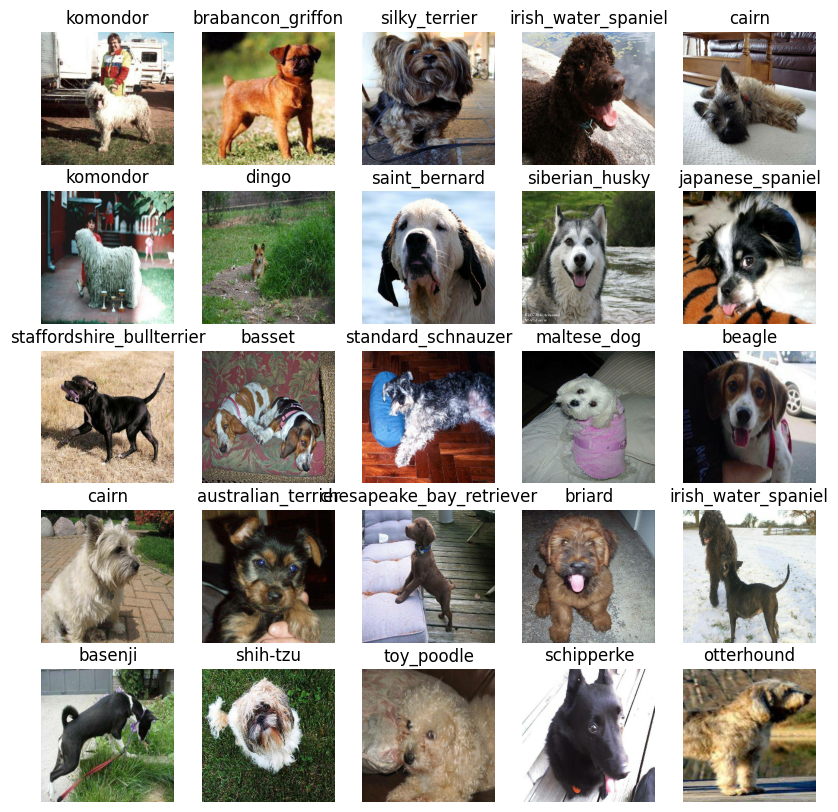

In [68]:
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels) 

### Validation Images

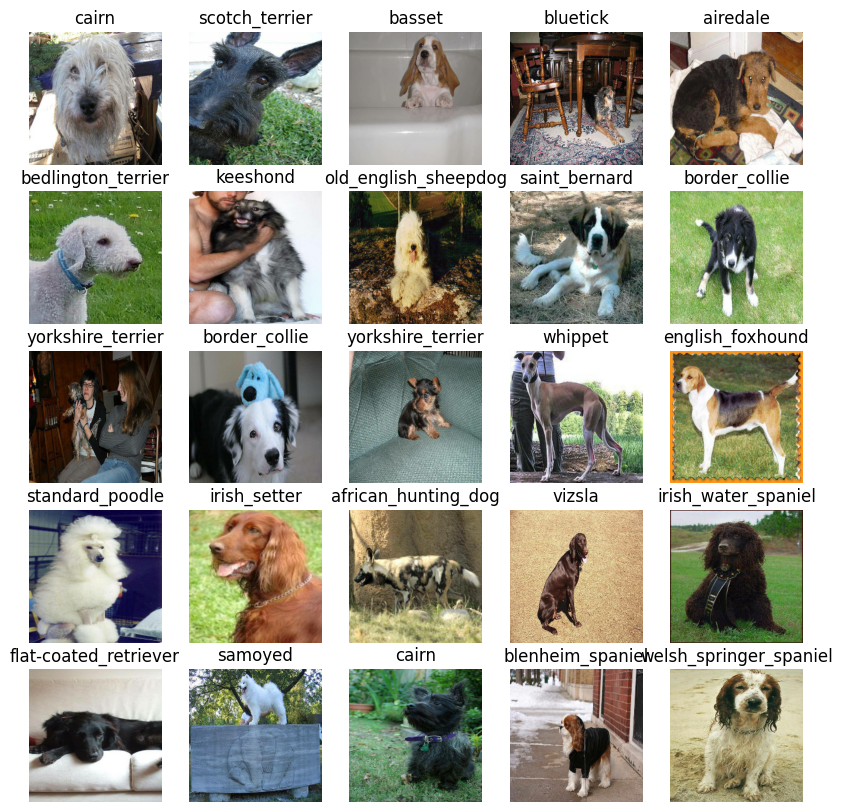

In [69]:
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

### Build Model

To build a model,  the following must be defined:
- Input shape - shape of images
- Output shape - shape of labels
- URL of the model to be used from Tensorflow Hub

In [70]:
# Shape of Images
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]

# Shape of labels
OUTPUT_SHAPE = len(unique_breeds)

# setup model URL
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

# Create a funtion to:
- takes input, output shapes and model as parameters
- defines layers in a Keras model in sequential
- compiles de model
- builds the model
- returns the model

In [71]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    print("Building a Model with the URL: ", MODEL_URL)

    # Setup Keras layers: Instatiate the model
    model = tf.keras.Sequential([
        hub.KerasLayer(MODEL_URL), # Layer1: input layer
        tf.keras.layers.Dense(units=OUTPUT_SHAPE, # LAYER2: output layer
                             activation="softmax") # multiclass classification: softmax, binary classification:sigmoid
    ])

    # Compiling the model
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    # Build the model
    model.build(INPUT_SHAPE)

    return model

model = create_model()
model.summary()
    

Building a Model with the URL:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_3 (Dense)             (None, 10222)             10242444  
                                                                 
Total params: 15675157 (59.80 MB)
Trainable params: 10242444 (39.07 MB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


### Create Callbacks
- Tensorboard Callbacks
- Early stopping callback

In [72]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [74]:
import datetime

def create_tensorboard_callback():
    # Create a logdir for storing tensorboard logs
    logdir = os.path.join("./logs", 
                         datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return tf.keras.callbacks.TensorBoard(logdir)    

### Early Stopping Callback

*Keep finding patterns until the quality of these patterns starts to go down*

In [75]:
NUM_EPOCHS = 15 # number of chances the model have to improve

In [76]:
def train_model():
    # Create model
    model = create_model()

    tensorboard = create_tensorboard_callback()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3)

    model.fit(x=train_data,
             epochs=NUM_EPOCHS,
             validation_data=val_data,
             validation_freq=1,
             callbacks=[tensorboard, early_stopping])
    return model

model = train_model()    

Building a Model with the URL:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/15
25/25 [==============================] - 21s 731ms/step - loss: 740.8407 - accuracy: 0.0025 - val_loss: 643.4808 - val_accuracy: 0.0050
Epoch 2/15
25/25 [==============================] - 18s 716ms/step - loss: 513.4549 - accuracy: 0.0088 - val_loss: 554.9490 - val_accuracy: 0.0000e+00
Epoch 3/15
25/25 [==============================] - 19s 755ms/step - loss: 442.9185 - accuracy: 0.0100 - val_loss: 538.6353 - val_accuracy: 0.0000e+00
Epoch 4/15
25/25 [==============================] - 18s 718ms/step - loss: 425.5763 - accuracy: 0.0113 - val_loss: 543.8579 - val_accuracy: 0.0000e+00
Epoch 5/15
25/25 [==============================] - 18s 712ms/step - loss: 421.2384 - accuracy: 0.0113 - val_loss: 562.0900 - val_accuracy: 0.0000e+00
Epoch 6/15
25/25 [==============================] - 18s 713ms/step - loss: 419.5123 - accuracy: 0.0113 - val_loss: 577.8022 - val_accuracy: 0.000

In [77]:
%tensorboard --logdir=./logs

Reusing TensorBoard on port 6006 (pid 231650), started 1:57:49 ago. (Use '!kill 231650' to kill it.)

In [78]:
predictions = model.predict(val_data, verbose=1)
predictions.shape

7/7 [==============================] - 4s 471ms/step


(200, 10222)

In [79]:
def print_predict(predictions):
    for i in range(len(predictions)):
        print("\n\n", i)
        print(f"Max value (probability of prediction): {np.max(predictions[i])}")
        print(f"Sum: {np.sum(predictions[i])}")
        print(f"Max index: {np.argmax(predictions[i])}")
        print(f"Predicted label: {unique_breeds[np.argmax(predictions[i])]}")

print_predict(predictions=predictions)



 0
Max value (probability of prediction): 0.02694684825837612
Sum: 1.0
Max index: 4879
Predicted label: cairn


 1
Max value (probability of prediction): 0.027979260310530663
Sum: 1.0000001192092896
Max index: 9162
Predicted label: scotch_terrier


 2
Max value (probability of prediction): 0.0343596376478672
Sum: 1.0
Max index: 10130
Predicted label: basset


 3
Max value (probability of prediction): 0.037263207137584686
Sum: 1.0
Max index: 952
Predicted label: lakeland_terrier


 4
Max value (probability of prediction): 0.02411920577287674
Sum: 0.9999998807907104
Max index: 3272
Predicted label: airedale


 5
Max value (probability of prediction): 0.020946597680449486
Sum: 1.0
Max index: 2215
Predicted label: bedlington_terrier


 6
Max value (probability of prediction): 0.03100637160241604
Sum: 1.0000001192092896
Max index: 7621
Predicted label: keeshond


 7
Max value (probability of prediction): 0.031345486640930176
Sum: 0.9999999403953552
Max index: 1757
Predicted label: old_eng

In [80]:
def get_pred_label(prediction_probabilities):
    return unique_breeds[np.argmax(prediction_probabilities)]

pred_label = get_pred_label(predictions[0])
pred_label

'cairn'

In [81]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10222), dtype=tf.bool, name=None))>

In [82]:
def unbatchify(data):
    images = []
    labels = []

    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_breeds[np.argmax(label)])
    return images, labels

val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

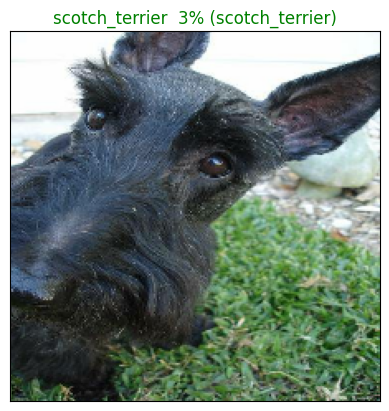

In [83]:
def plot_pred(prediction_probabilities, labels, images, n=1):
    """
    Visualize prediction
    """
    pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

    pred_label = get_pred_label(pred_prob)

    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    if pred_label == true_label:
        color = "green"
    else:
        color = "red"

    plt.title("{} {:2.0f}% ({})".format(pred_label,
                                       np.max(pred_prob)*100,
                                       true_label), color=color)

plot_pred(prediction_probabilities=predictions,
         labels=val_labels,
         images=val_images)    
        

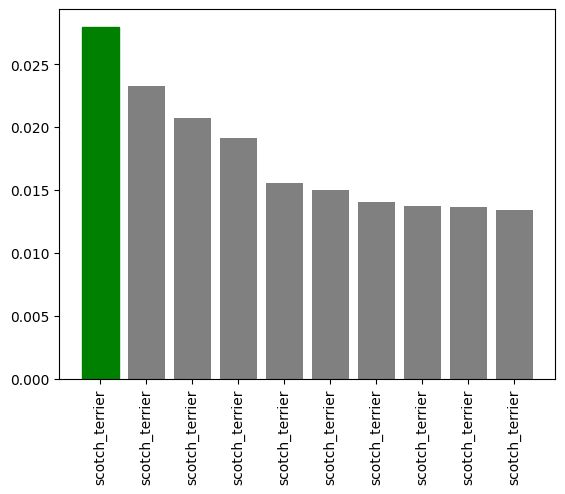

In [85]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
    """
    Plots top 10 highest prediction confidences along with the truth label for sample n
    """
    pred_prob, true_label = prediction_probabilities[n], labels[n]

    pred_label = get_pred_label(pred_prob)

    top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
    top_10_pred_values = pred_prob[top_10_pred_indexes]
    top_10_pred_labels = unique_breeds[top_10_pred_indexes]

     # Setup plot
    top_plot = plt.bar(np.arange(len(top_10_pred_labels)),top_10_pred_values,color="grey")
    plt.xticks(np.arange(len(top_10_pred_labels)),labels=top_10_pred_labels,rotation="vertical")

    # Change color of true label
    if np.isin(true_label, top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
    else:
        pass


plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=1)
    

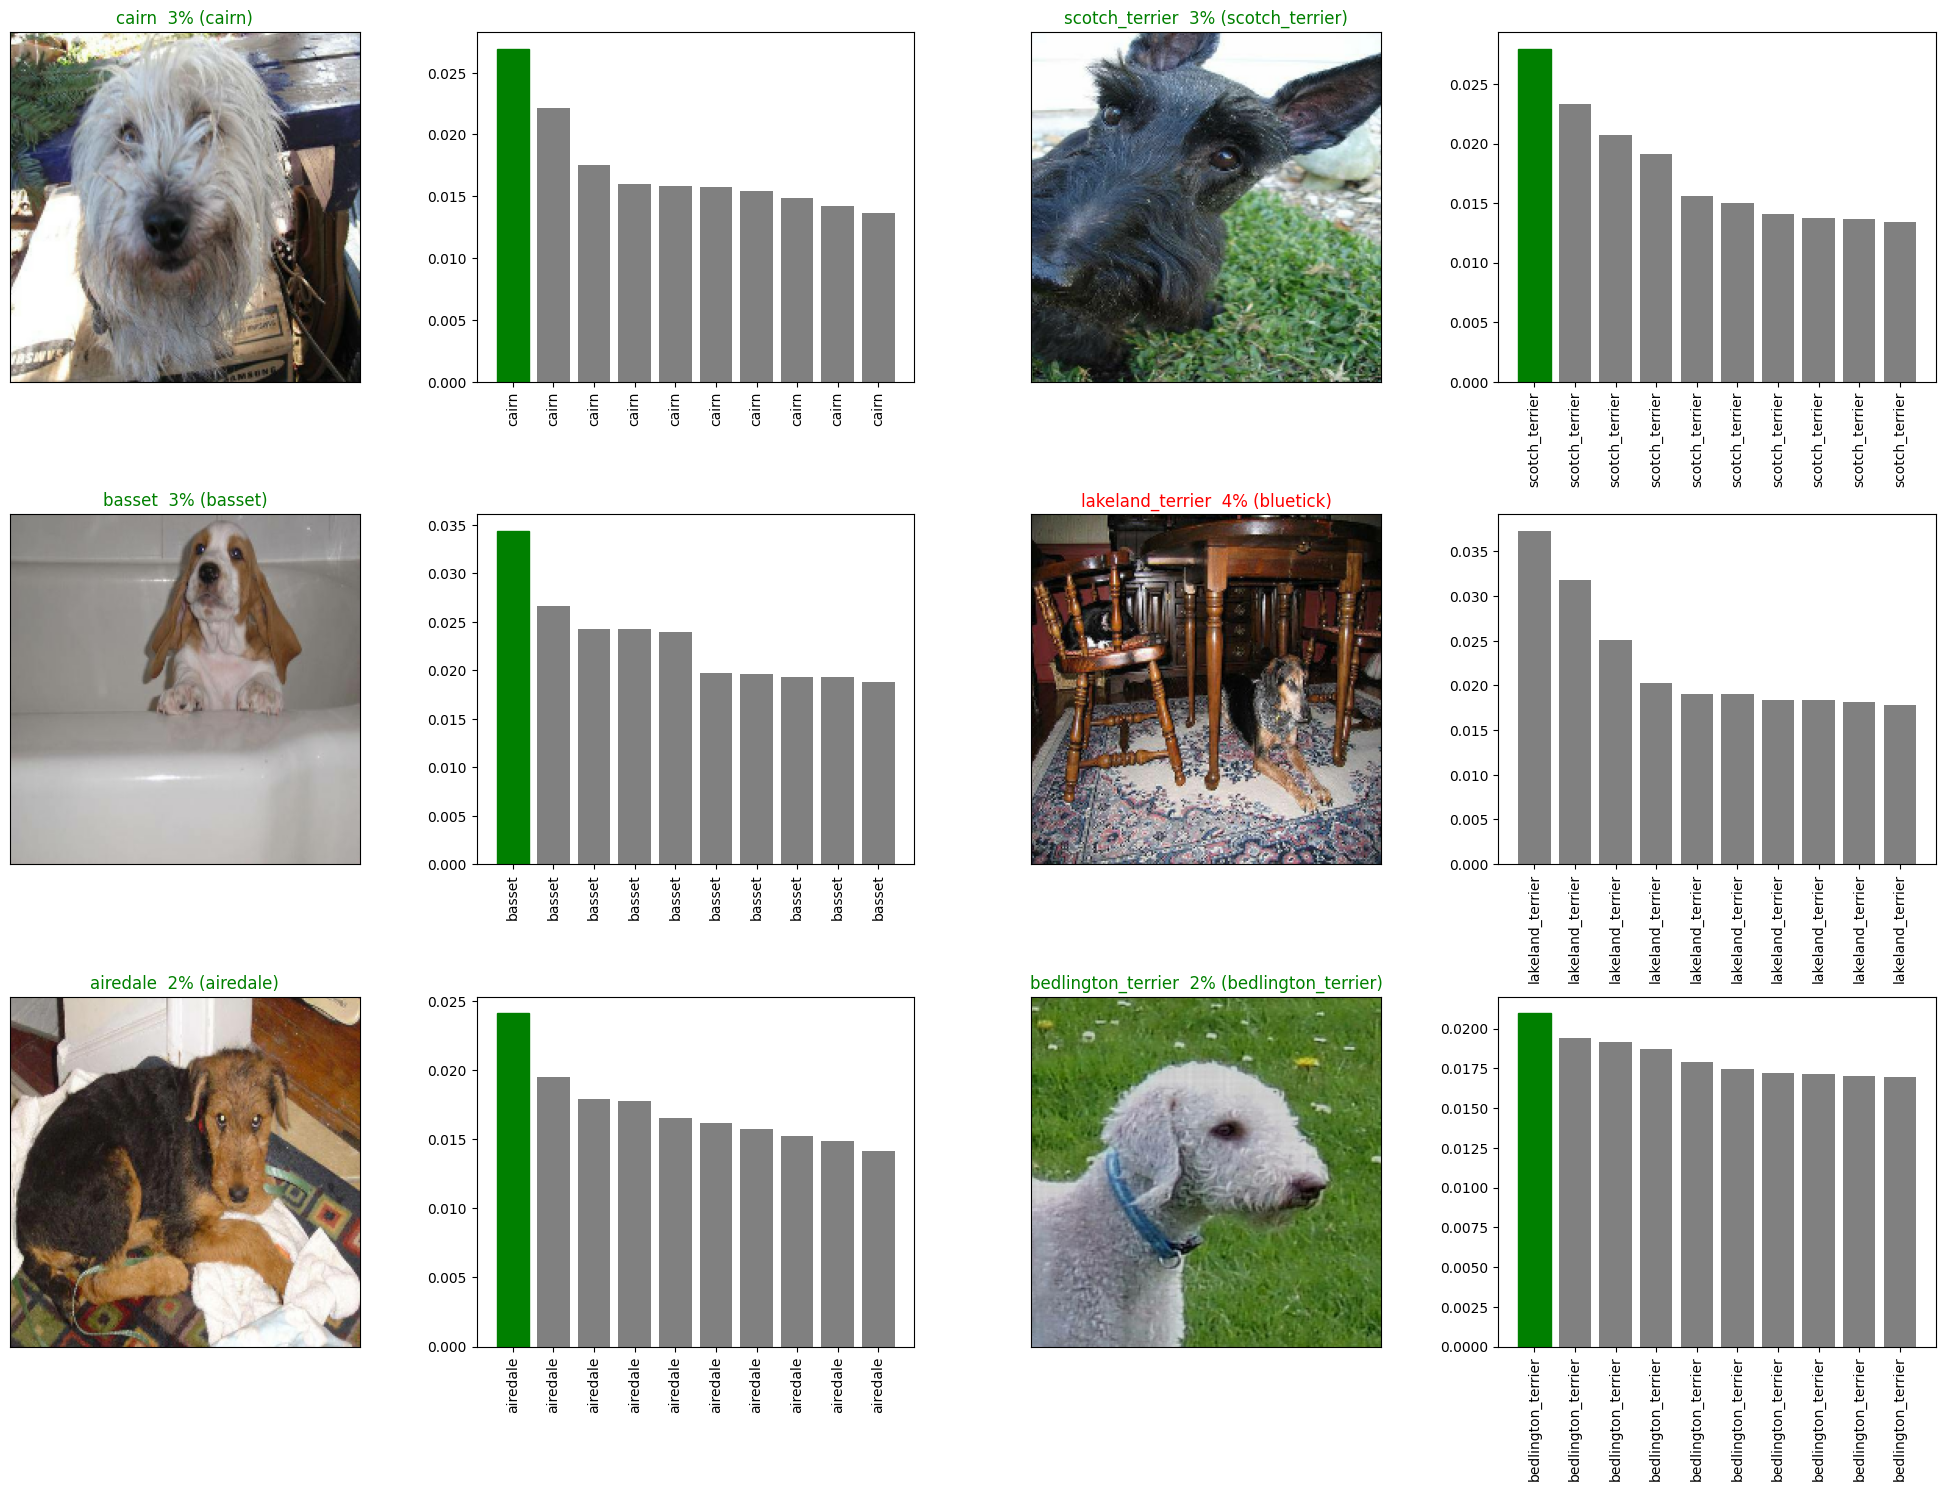

In [86]:
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_pred(prediction_probabilities=predictions,
              labels=val_labels,
              images=val_images,
              n=i+i_multiplier)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_pred_conf(prediction_probabilities=predictions,
                   labels=val_labels,
                   n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

### Saving & Loading the Model

In [88]:
def save_model(model, suffix=None):
    """
    Saves a given model in a models directory and appends a suffix (str)
    for clarity and reuse.
    """
    # Create model directory with current time
    modeldir = os.path.join("./models",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    model_path = modeldir + "-" + suffix + ".keras"  # save format of model
    print(f"Saving model to: {model_path}...")
    model.save(model_path)
    return model_path

def load_model(model_path):
    """
    Loads a saved model from a specified path.
    """
    print(f"Loading saved model from: {model_path}")
    model = tf.keras.models.load_model(model_path,
                                       custom_objects={"KerasLayer": hub.KerasLayer})
    return model

save_model(model, suffix="1000-images-Adam")

Saving model to: ./models/20240715-181028-1000-images-Adam.keras...


'./models/20240715-181028-1000-images-Adam.keras'

# Training the Model on the Full Dataset

In [89]:
# Turn full training data in a data batch
full_data = create_batches(X, y)

# Instantiate a new model for training on the full dataset
full_model = create_model()

# Create full model callbacks

# TensorBoard callback
full_model_tensorboard = create_tensorboard_callback()

# Early stopping callback
# Note: No validation set when training on all the data, therefore can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

%tensorboard --logdir=./logs

Creating Training Data Batches...
Building a Model with the URL:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


Reusing TensorBoard on port 6006 (pid 231650), started 2:23:52 ago. (Use '!kill 231650' to kill it.)

In [90]:
# Fit the full model to the full training data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, 
                          full_model_early_stopping])
# Save model to file
save_model(full_model, suffix="all-images-Adam")

# Load in the full model
loaded_full_model = load_model('./models/20240715-181028-1000-images-Adam.keras')

Epoch 1/15
320/320 [==============================] - 178s 547ms/step - loss: 528.7635 - accuracy: 0.0073
Epoch 2/15
320/320 [==============================] - 180s 562ms/step - loss: 555.7812 - accuracy: 0.0095
Epoch 3/15
320/320 [==============================] - 199s 621ms/step - loss: 638.9235 - accuracy: 0.0091
Epoch 4/15
320/320 [==============================] - 191s 595ms/step - loss: 724.7224 - accuracy: 0.0092
Epoch 5/15
320/320 [==============================] - 196s 611ms/step - loss: 802.1965 - accuracy: 0.0090
Saving model to: ./models/20240715-182809-all-images-Adam.keras...
Loading saved model from: ./models/20240715-181028-1000-images-Adam.keras


In [93]:
# Load test image filenames (since we're using os.listdir(), these already have .jpg)
test_path = "./dataset/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]

# Create test data batch
test_data = create_batches(test_filenames, test_data=True)

# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

Creating Test data Batches...
324/324 [==============================] - 168s 519ms/step


In [92]:
# Create pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

# Append test image ID's to predictions DataFrame
preds_df["id"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]

# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions

preds_df.to_csv("./full_submission_1_mobilienetV2_adam.csv",
                 index=False)

ValueError: Columns must be same length as key